In [1]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import pandas as pd
import numpy as np
import glob
import networkx as nx
import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, GES, ICALiNGAM, GOLEM
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

2025-03-21 17:00:09,385 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
combined_df = pd.read_excel("C:/Users/IU Student/Downloads/causal_inference_dataset.xlsx")

In [3]:
data = combined_df.loc[:, ~combined_df.columns.str.startswith('pct') & 
                   ~combined_df.columns.str.contains('_ed_|_rt_|housing_') ]
data

,Unnamed: 0.1,Unnamed: 0,year_of,fips_code,state,county,state_code,county_type,hh_median_income,home_own_hh_median_income,...,amt_grant,rurality_pct,county_class,hs_gte_hs_degree,grant_amount_per_household,treatment_variable,county_class_Exurban,county_class_Rural,county_class_Suburban,county_class_Urban
0,0,0,2021,0500000US01051,Alabama,Elmore County,AL,Large,59032,70162,...,87455,46,Exurban,0.894543,2.723776,1,1,0,0,0
1,1,1,2021,0500000US01073,Alabama,Jefferson County,AL,Large,55006,73199,...,5213523,31,Urban,0.920810,19.298837,1,0,0,0,1
2,2,2,2021,0500000US01083,Alabama,Limestone County,AL,Large,66796,91630,...,31352,45,Exurban,0.869411,0.770603,0,1,0,0,0
3,3,3,2021,0500000US01089,Alabama,Madison County,AL,Large,78525,96065,...,1484538,35,Urban,0.951621,9.024931,1,0,0,0,1
4,4,4,2021,0500000US01095,Alabama,Marshall County,AL,Large,50191,60585,...,314,45,Exurban,0.845041,0.008721,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37706,37706,3138,2011,0500000US56019,Wyoming,Johnson County,WY,Small,55094,60314,...,0,62,Rural,0.925877,0.000000,0,0,1,0,0
37707,37707,3139,2011,0500000US56009,Wyoming,Converse County,WY,Small,56673,66493,...,0,59,Rural,0.927580,0.000000,0,0,1,0,0
37708,37708,3140,2011,0500000US56039,Wyoming,Teton County,WY,Small,73627,96478,...,0,57,Rural,0.983699,0.000000,0,0,1,0,0
37709,37709,3141,2011,0500000US56005,Wyoming,Campbell County,WY,Small,78356,86636,...,0,56,Rural,0.931128,0.000000,0,0,1,0,0


In [4]:
# Identify columns that start with 'home_own_' and 'rent_'
home_own_cols = [col for col in data.columns if col.startswith('home_own_')]
rent_cols = [col for col in data.columns if col.startswith('rent_')]

# Create new combined columns by summing matching pairs
for home_col in home_own_cols:
    suffix = home_col.replace('home_own_', '')  # Extract the suffix (xyz)
    
    # Skip processing for median_income columns
    if suffix == "median_income":
        continue
    
    rent_col = f"rent_{suffix}"  # Corresponding rent column
    
    if rent_col in data.columns:  # Ensure the rent column exists
        data[f"combined_{suffix}"] = data[home_col] + data[rent_col]

# Optionally, drop the original columns if you no longer need them
data.drop(columns=[col for col in home_own_cols + rent_cols if "median_income" not in col], inplace=True)
data

,Unnamed: 0.1,Unnamed: 0,year_of,fips_code,state,county,state_code,county_type,hh_median_income,home_own_hh_median_income,...,combined_hh_inc_015_020k,combined_hh_inc_020_025k,combined_hh_inc_025_035k,combined_hh_inc_035_050k,combined_hh_inc_050_075k,combined_hh_inc_075_100k,combined_hh_inc_100_150k,combined_hh_inc_150k_ge,combined_children_present,combined_children_absent
0,0,0,2021,0500000US01051,Alabama,Elmore County,AL,Large,59032,70162,...,1931,792,2878,5953,4602,4235,5975,2582,7326,24782
1,1,1,2021,0500000US01073,Alabama,Jefferson County,AL,Large,55006,73199,...,13699,13317,22849,36015,48386,30497,34635,35156,60025,210122
2,2,2,2021,0500000US01083,Alabama,Limestone County,AL,Large,66796,91630,...,2602,920,3111,4440,7033,4277,7149,7547,12397,28288
3,3,3,2021,0500000US01089,Alabama,Madison County,AL,Large,78525,96065,...,4831,4555,10054,19778,24920,24314,27927,34758,43819,120674
4,4,4,2021,0500000US01095,Alabama,Marshall County,AL,Large,50191,60585,...,1670,2756,3473,5092,6493,3801,3958,3817,10032,25971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37706,37706,3138,2011,0500000US56019,Wyoming,Johnson County,WY,Small,55094,60314,...,77,201,291,673,893,488,395,255,856,2940
37707,37707,3139,2011,0500000US56009,Wyoming,Converse County,WY,Small,56673,66493,...,258,346,658,673,1216,971,790,298,1528,4163
37708,37708,3140,2011,0500000US56039,Wyoming,Teton County,WY,Small,73627,96478,...,173,309,597,959,1345,1196,1239,1093,1673,5647
37709,37709,3141,2011,0500000US56005,Wyoming,Campbell County,WY,Small,78356,86636,...,332,432,1162,1727,3469,3290,3798,1524,6006,10577


In [5]:
analysis_data = data[(data['year_of'] == 2019) | (data['year_of'] == 2022)].copy()
wide_df = analysis_data.pivot(index=['county', 'fips_code', 'state', 'rurality_pct', 'county_class', 'county_class_Exurban', 'county_class_Rural', 'county_class_Suburban', 'county_class_Urban'], columns='year_of', values=[
    'hh_median_income',
    'combined_hispanic',
    'home_own_hh_median_income',
    'vacant',
    'unemployed',
    'home_value_0000_0049k',
    'combined_black',
    'rent_hh_median_income',
    'combined_hh_inc_025_035k',
    'home_value_0200_0299k',
    'combined_hh_inc_035_050k',
    'combined_hh_size_6',
    'personal_income',
    'combined_hh_inc_050_075k',
    'combined_hh_inc_000_005k',
    'combined_age_35_44',
    'combined_age_35_lt',
    'combined_age_45_54',
    'combined_children_present',
    'grant_amount_per_household',
    'hs_gte_hs_degree',
    'treatment_variable']).reset_index()
wide_df

county       fips_code           state rurality_pct  \
year_of                                                                  
0        Abbeville County  0500000US45001  South Carolina           52   
1           Acadia Parish  0500000US22001       Louisiana           48   
2         Accomack County  0500000US51001        Virginia           51   
3              Ada County  0500000US16001           Idaho           38   
4            Adair County  0500000US19001            Iowa           57   
...                   ...             ...             ...          ...   
3148          Yuma County  0500000US04027         Arizona           47   
3149          Yuma County  0500000US08125        Colorado           60   
3150        Zapata County  0500000US48505           Texas           56   
3151        Zavala County  0500000US48507           Texas           58   
3152       Ziebach County  0500000US46137    South Dakota           64   

        county_class county_class_Exurban county_class_Rural  \
year_of                                                        
0              Rural                    0                  1   
1            Exurban                    1                  0   
2              Rural                    0                  1   
3           Suburban                    0                  0   
4              Rural                    0                  1   
...              ...                  ...                ...   
3148         Exurban                    1                  0   
3149           Rural                    0                  1   
3150           Rural                    0                  1   
3151           Rural                    0                  1   
3152           Rural                    0                  1   

        county_class_Suburban county_class_Urban hh_median_income  ...  \
year_of                                                      2019  ...   
0                           0                  0          38741.0  ...   
1                           0                  0          43396.0  ...   
2                           0                  0          46073.0  ...   
3                           1                  0          72021.0  ...   
4                           0                  0          53363.0  ...   
...                       ...                ...              ...  ...   
3148                        0                  0          46419.0  ...   
3149                        0                  0          52022.0  ...   
3150                        0                  0          33952.0  ...   
3151                        0                  0          34459.0  ...   
3152                        0                  0          37400.0  ...   

        combined_age_45_54          combined_children_present           \
year_of               2019     2022                      2019     2022   
0                   1833.0   1672.0                    2052.0   1987.0   
1                   3560.0   3709.0                    6884.0   6553.0   
2                   2166.0   2271.0                    2580.0   2808.0   
3                  33608.0  36551.0                   52646.0  58464.0   
4                    417.0    459.0                     707.0    759.0   
...                    ...      ...                       ...      ...   
3148               11800.0  12156.0                   21727.0  23703.0   
3149                 690.0    790.0                    1203.0   1415.0   
3150                 844.0    790.0                    1849.0   1983.0   
3151                 468.0    430.0                    1076.0   1155.0   
3152                 156.0    134.0                     230.0    170.0   

        grant_amount_per_household      hs_gte_hs_degree            \
year_of                       2019 2022             2019      2022   
0                         0.000000  0.0         0.832176  0.874079   
1                         0.387879  0.0         0.805747  0.816466   
2                

In [6]:
wide_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in wide_df.columns]
wide_df

,county,fips_code,state,rurality_pct,county_class,county_class_Exurban,county_class_Rural,county_class_Suburban,county_class_Urban,hh_median_income_2019,...,combined_age_45_54_2019,combined_age_45_54_2022,combined_children_present_2019,combined_children_present_2022,grant_amount_per_household_2019,grant_amount_per_household_2022,hs_gte_hs_degree_2019,hs_gte_hs_degree_2022,treatment_variable_2019,treatment_variable_2022
0,Abbeville County,0500000US45001,South Carolina,52,Rural,0,1,0,0,38741.0,...,1833.0,1672.0,2052.0,1987.0,0.000000,0.0,0.832176,0.874079,0.0,0.0
1,Acadia Parish,0500000US22001,Louisiana,48,Exurban,1,0,0,0,43396.0,...,3560.0,3709.0,6884.0,6553.0,0.387879,0.0,0.805747,0.816466,0.0,0.0
2,Accomack County,0500000US51001,Virginia,51,Rural,0,1,0,0,46073.0,...,2166.0,2271.0,2580.0,2808.0,10.709586,0.0,0.832405,0.825332,1.0,0.0
3,Ada County,0500000US16001,Idaho,38,Suburban,0,0,1,0,72021.0,...,33608.0,36551.0,52646.0,58464.0,13.152161,0.0,0.959883,0.967048,1.0,0.0
4,Adair County,0500000US19001,Iowa,57,Rural,0,1,0,0,53363.0,...,417.0,459.0,707.0,759.0,0.000000,0.0,0.965087,0.977150,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,Yuma County,0500000US04027,Arizona,47,Exurban,1,0,0,0,46419.0,...,11800.0,12156.0,21727.0,23703.0,0.330893,0.0,0.755706,0.775418,0.0,0.0
3149,Yuma County,0500000US08125,Colorado,60,Rural,0,1,0,0,52022.0,...,690.0,790.0,1203.0,1415.0,23.779819,0.0,0.890267,0.890369,1.0,0.0
3150,Zapata County,0500000US48505,Texas,56,Rural,0,1,0,0,33952.0,...,844.0,790.0,1849.0,1983.0,0.000000,0.0,0.626249,0.692023,0.0,0.0
3151,Zavala County,0500000US48507,Texas,58,Rural,0,1,0,0,34459.0,...,468.0,430.0,1076.0,1155.0,0.000000,0.0,0.659078,0.785754,0.0,0.0


In [7]:
wide_df.isna().sum()
wide_df.replace([float('inf'), -float('inf')], pd.NA).isna().sum()
wide_df = wide_df.fillna(0)  

In [8]:
print(wide_df.dtypes)


county                              object
fips_code                           object
state                               object
rurality_pct                         int64
county_class                        object
county_class_Exurban                 int64
county_class_Rural                   int64
county_class_Suburban                int64
county_class_Urban                   int64
hh_median_income_2019              float64
hh_median_income_2022              float64
combined_hispanic_2019             float64
combined_hispanic_2022             float64
home_own_hh_median_income_2019     float64
home_own_hh_median_income_2022     float64
vacant_2019                        float64
vacant_2022                        float64
unemployed_2019                    float64
unemployed_2022                    float64
home_value_0000_0049k_2019         float64
home_value_0000_0049k_2022         float64
combined_black_2019                float64
combined_black_2022                float64
rent_hh_med

In [9]:
# Define treatment, outcome, and confounders
treatment = "treatment_variable_2019"
outcome = "hs_gte_hs_degree_2022"
# confounders = ["combined_children_present_2019", 
#                'combined_age_35_lt_2019', 
#                'combined_hh_inc_050_075k_2019', 
#                'home_value_0000_0049k_2019']

In [10]:
print(wide_df.columns)

Index(['county', 'fips_code', 'state', 'rurality_pct', 'county_class',
       'county_class_Exurban', 'county_class_Rural', 'county_class_Suburban',
       'county_class_Urban', 'hh_median_income_2019', 'hh_median_income_2022',
       'combined_hispanic_2019', 'combined_hispanic_2022',
       'home_own_hh_median_income_2019', 'home_own_hh_median_income_2022',
       'vacant_2019', 'vacant_2022', 'unemployed_2019', 'unemployed_2022',
       'home_value_0000_0049k_2019', 'home_value_0000_0049k_2022',
       'combined_black_2019', 'combined_black_2022',
       'rent_hh_median_income_2019', 'rent_hh_median_income_2022',
       'combined_hh_inc_025_035k_2019', 'combined_hh_inc_025_035k_2022',
       'home_value_0200_0299k_2019', 'home_value_0200_0299k_2022',
       'combined_hh_inc_035_050k_2019', 'combined_hh_inc_035_050k_2022',
       'combined_hh_size_6_2019', 'combined_hh_size_6_2022',
       'personal_income_2019', 'personal_income_2022',
       'combined_hh_inc_050_075k_2019', 'combin

In [11]:
confounders = ['hh_median_income_2019',
 'combined_hispanic_2019',
 'home_own_hh_median_income_2019', 
 'vacant_2019', 
 'rurality_pct',
 'unemployed_2019',
 'home_value_0000_0049k_2019', 
 'combined_black_2019', 
 'rent_hh_median_income_2019', 
 'combined_hh_inc_025_035k_2019',
 'home_value_0200_0299k_2019', 
 'combined_hh_inc_035_050k_2019', 
 'combined_hh_size_6_2019', 
 'personal_income_2019', 
 'combined_hh_inc_050_075k_2019', 
 'combined_hh_inc_000_005k_2019', 
 'combined_age_35_44_2019', 
 'combined_age_35_44_2019', 
 'combined_age_45_54_2019', 
 'county_class_Rural']

In [12]:
data = wide_df[confounders+[treatment, outcome]]



In [13]:
data.shape

(3153, 22)

In [14]:
placebo = np.random.randn(3153, 1)
data_with_placebo = np.hstack([data, placebo])


In [15]:
data_with_placebo.shape

(3153, 23)

# PC

In [16]:
pc = PC()  
pc.learn(data.values)  

causal_matrix = pc.causal_matrix

print("Learned Causal Matrix (Adjacency Matrix):")
print(causal_matrix)

Learned Causal Matrix (Adjacency Matrix):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 

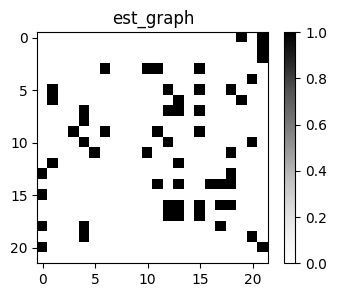

In [17]:
# Visualize the learned causal graph
graph = GraphDAG(causal_matrix)

### Data with placebo

In [18]:
pc = PC()  
pc.learn(data_with_placebo)  

causal_matrix_p = pc.causal_matrix

print("Learned Causal Matrix (Adjacency Matrix):")
print(causal_matrix_p)

Learned Causal Matrix (Adjacency Matrix):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0

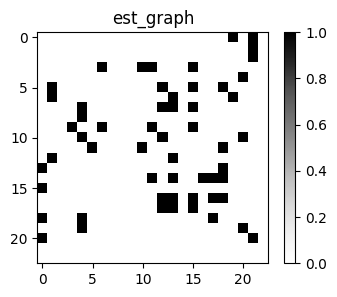

In [19]:
# Visualize the learned causal graph
graph = GraphDAG(causal_matrix_p)

# Notears

2025-03-21 17:01:57,549 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\linear.py[line:195] - INFO: [start]: n=3153, d=22, iter_=100, h_=1e-08, rho_=1e+16
2025-03-21 17:01:57,692 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 0] h=1.118e-01, loss=1074357951812558.125, rho=1.0e+00
2025-03-21 17:01:57,761 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 1] h=2.215e-01, loss=858164013628112.250, rho=1.0e+00
2025-03-21 17:01:57,836 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 1] h=2.215e-01, loss=858164013628112.250, rho=1.0e+01
2025-03-21 17:01:57,912 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-p

[[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0

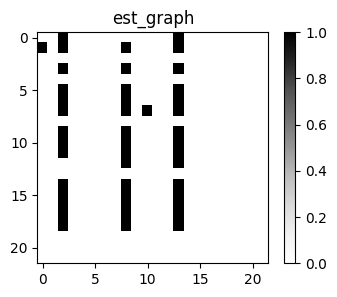

In [20]:
from castle.algorithms import Notears

# Apply NOTEARS (another causal discovery algorithm)
notears = Notears()
notears.learn(data.values)

# Get the learned causal structure from NOTEARS
notears_causal_matrix = notears.causal_matrix
print(notears_causal_matrix)
# Visualize the NOTEARS causal graph
notears_graph = GraphDAG(notears_causal_matrix)

### Data with placebo

2025-03-21 17:02:09,466 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\linear.py[line:195] - INFO: [start]: n=3153, d=23, iter_=100, h_=1e-08, rho_=1e+16
2025-03-21 17:02:09,597 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 0] h=1.120e-01, loss=1074357951812558.250, rho=1.0e+00
2025-03-21 17:02:09,678 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 1] h=2.227e-01, loss=858164013628969.125, rho=1.0e+00
2025-03-21 17:02:09,763 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\linear.py[line:206] - INFO: [iter 1] h=2.227e-01, loss=858164013628969.250, rho=1.0e+01
2025-03-21 17:02:09,854 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-p

[[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 

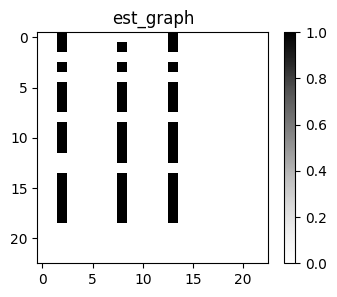

In [21]:
notears = Notears()
notears.learn(data_with_placebo)

# Get the learned causal structure from NOTEARS
notears_causal_matrix = notears.causal_matrix
print(notears_causal_matrix)
# Visualize the NOTEARS causal graph
notears_graph = GraphDAG(notears_causal_matrix)

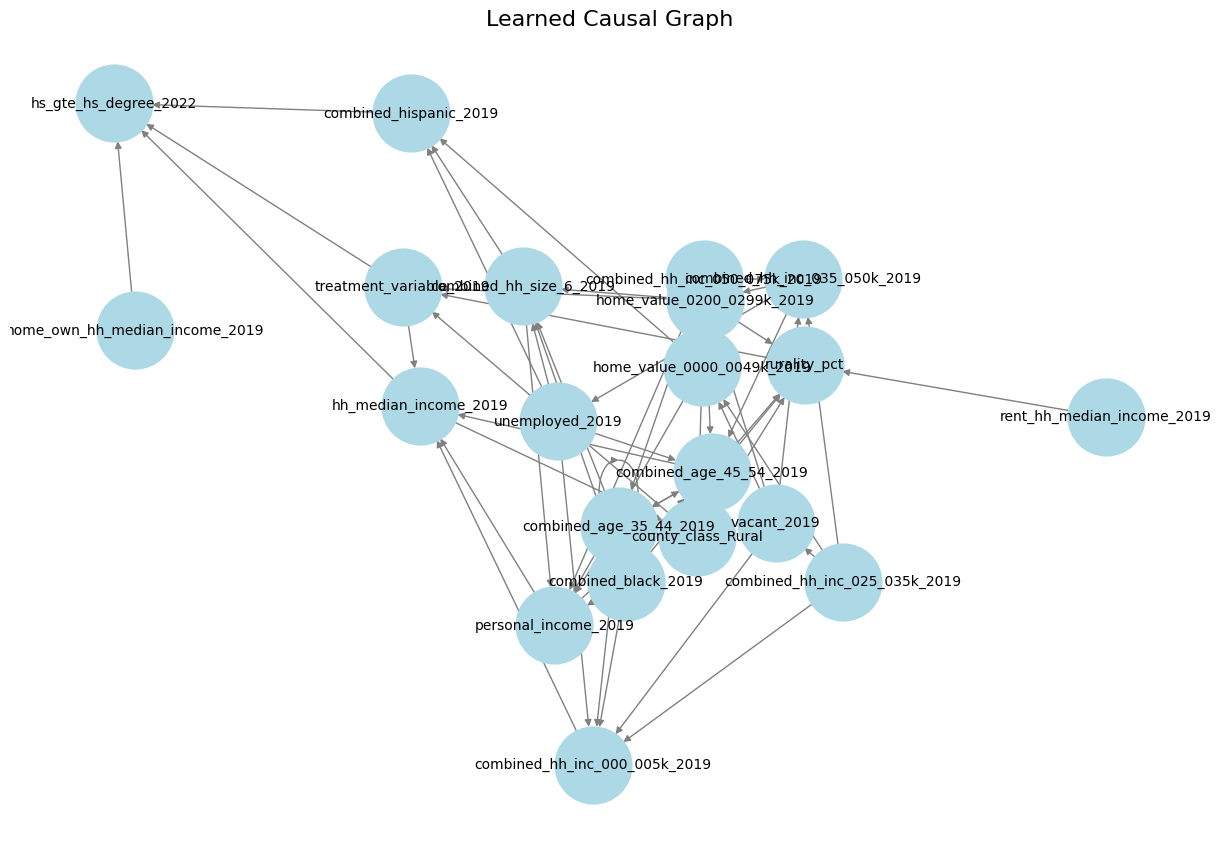

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
from castle.common import GraphDAG

labels = data.columns.tolist()  

G = nx.DiGraph(causal_matrix)

mapping = {i: label for i, label in enumerate(labels)}
G = nx.relabel_nodes(G, mapping)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', 
        node_size=3000, font_size=10, arrows=True, linewidths=1.5)
plt.title("Learned Causal Graph", fontsize=16)
plt.show()


# Direct LiNGAM

In [23]:
from castle.algorithms import DirectLiNGAM
dl = DirectLiNGAM()
dl.learn(data)
causal_matrix_dl = dl.causal_matrix
np.set_printoptions(linewidth=200, threshold=np.inf)
print("Learned Causal Matrix (Adjacency Matrix):")
print(causal_matrix_dl)

Learned Causal Matrix (Adjacency Matrix):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0]
 [1 0 0 1 1 1 0 0 

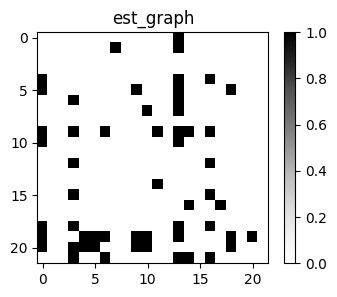

In [24]:
dl_graph = GraphDAG(causal_matrix_dl)

### Data with placebo

Learned Causal Matrix (Adjacency Matrix):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 1 1 1 0 0 1 1 0 0

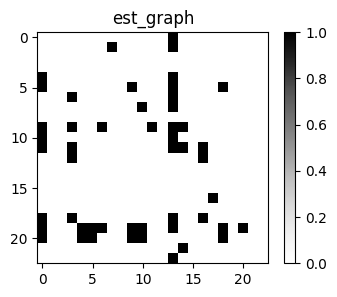

In [25]:
from castle.algorithms import DirectLiNGAM
dl = DirectLiNGAM()
dl.learn(data_with_placebo)
causal_matrix_dl = dl.causal_matrix

print("Learned Causal Matrix (Adjacency Matrix):")
print(causal_matrix_dl)
dl_graph = GraphDAG(causal_matrix_dl)

# Notears - MLP

In [26]:
from castle.algorithms import NotearsNonlinear

ntnl = NotearsNonlinear()
ntnl.learn(data)
causal_matrix_ntnl = ntnl.causal_matrix

print("Learned Causal Matrix (Adjacency Matrix):")
print(causal_matrix_ntnl)

2025-03-21 17:02:40,644 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:137] - INFO: GPU is unavailable.
2025-03-21 17:02:40,647 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:237] - INFO: [start]: n=3153, d=22, iter_=100, h_=1e-08, rho_=1e+16
2025-03-21 17:02:59,115 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:249] - INFO: FINISHED


Learned Causal Matrix (Adjacency Matrix):
[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 

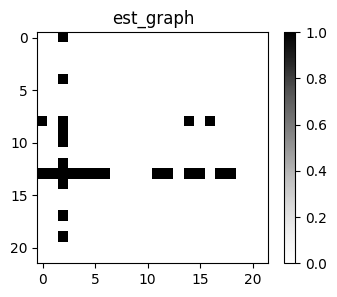

In [27]:
ntml_graph = GraphDAG(causal_matrix_ntnl)

### Data with placebo

In [28]:
ntnl = NotearsNonlinear()
ntnl.learn(data_with_placebo)
causal_matrix_ntnl = ntnl.causal_matrix

print("Learned Causal Matrix (Adjacency Matrix):")
print(causal_matrix_ntnl)

2025-03-21 17:03:08,898 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:137] - INFO: GPU is unavailable.
2025-03-21 17:03:08,900 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:237] - INFO: [start]: n=3153, d=23, iter_=100, h_=1e-08, rho_=1e+16
2025-03-21 17:03:23,106 - c:\Users\IU Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:249] - INFO: FINISHED


Learned Causal Matrix (Adjacency Matrix):
[[0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0

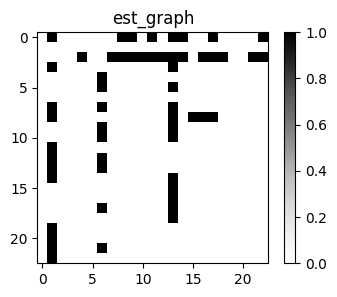

In [29]:
ntml_graph = GraphDAG(causal_matrix_ntnl)